# I. Intro to XGBoost and CatBoost


In [1]:
import gc
import os
import math
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import xgboost as xgb
import catboost
import time
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn.metrics import mean_absolute_error
import seaborn as sns

# Fifa Dataset

In [2]:
df = pd.read_csv('data/fifa.csv', index_col = 'Unnamed: 0')

In [3]:
df.head()

,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,Club Logo,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,https://cdn.sofifa.org/teams/2/light/241.png,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,https://cdn.sofifa.org/teams/2/light/45.png,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,https://cdn.sofifa.org/teams/2/light/73.png,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,https://cdn.sofifa.org/teams/2/light/11.png,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,https://cdn.sofifa.org/teams/2/light/10.png,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


We come back to the previous FiFa dataset, to compare the efficiency between LightGBM, XGBoost and CatBoost

In [4]:
def plot_feature_importance(feature_importance,title):
    fe = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
        by="importance", ascending=False)
    fe['feature'] = fe.index
    plt.figure(figsize=(16, 12))
    sns.barplot(x="importance", y="feature", data=fe)
    plt.xticks([])
    plt.title(title)
    return

### Objective: Predict `Overall`

**Exercise**: Redo exercices on Week 1A with XGBoost and CatBoost, using the same Pandas data treatment. Finetune the XGBoost and CatBoost parameters and compare the accuracy of 3 methods

In [12]:
def clean_df(df):
    df_clean = df.copy()
    for y in df_clean.columns:
        if not (df_clean[y].dtype == np.float64 or df_clean[y].dtype == np.int64):
            try:
                df_clean[y] = pd.to_numeric(df_clean[y])
                print(f'{y} column type has been changed to {df_clean[y].dtype}')
            except ValueError as e:
                # Drop column that could not be parse
                df_clean = df_clean.drop(columns=[y])
                print('error: ', e)
                print(f'{y} columns has been removed')
            
    return df_clean

In [13]:
X = clean_df(df)
y = X.Overall
X = X.drop(columns=["Overall", "Potential"])

error:  Unable to parse string "L. Messi" at position 0
Name columns has been removed
error:  Unable to parse string "https://cdn.sofifa.org/players/4/19/158023.png" at position 0
Photo columns has been removed
error:  Unable to parse string "Argentina" at position 0
Nationality columns has been removed
error:  Unable to parse string "https://cdn.sofifa.org/flags/52.png" at position 0
Flag columns has been removed
error:  Unable to parse string "FC Barcelona" at position 0
Club columns has been removed
error:  Unable to parse string "https://cdn.sofifa.org/teams/2/light/241.png" at position 0
Club Logo columns has been removed
error:  Unable to parse string "€110.5M" at position 0
Value columns has been removed
error:  Unable to parse string "€565K" at position 0
Wage columns has been removed
error:  Unable to parse string "Left" at position 0
Preferred Foot columns has been removed
error:  Unable to parse string "Medium/ Medium" at position 0
Work Rate columns has been removed
error: 

In [14]:
X.columns

Index(['ID', 'Age', 'Special', 'International Reputation', 'Weak Foot',
       'Skill Moves', 'Jersey Number', 'Crossing', 'Finishing',
       'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling', 'Curve',
       'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
       'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
       'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
       'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
       'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
       'GKKicking', 'GKPositioning', 'GKReflexes'],
      dtype='object')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [16]:
def calc_accuracy(y_pred, y):
    return sum(y_pred == y)/len(y)

#### LGB prediction

In [91]:
def train_lgb(X_train, X_valid, y_train, y_valid, params=None):

    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=['auc', 'binary_l2'],
            verbose=1, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance

In [92]:
lgb_params = {
          'n_estimators': 500,  # Number of trees
          'num_leaves': 60,  # max number of leaves in tree
          'min_data_in_leaf': 2,
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting": "gbdt",
          "bagging_freq": 10,
          'num_threads': 8,
          "bagging_fraction": 0.7,
          "bagging_seed": 11,
#           "metric": 'binary_l2',
         }

In [93]:
y_pred_train, y_pred_test, feature_importance = train_lgb(X_train, X_test, y_train, y_test, params=lgb_params)

[1]	training's auc: 1	training's l2: 46.352	valid_1's auc: 1	valid_1's l2: 44.8288
Training until validation scores don't improve for 50 rounds
[2]	training's auc: 1	training's l2: 44.7237	valid_1's auc: 1	valid_1's l2: 43.2646
[3]	training's auc: 1	training's l2: 43.1617	valid_1's auc: 1	valid_1's l2: 41.7578
[4]	training's auc: 1	training's l2: 41.6597	valid_1's auc: 1	valid_1's l2: 40.3194
[5]	training's auc: 1	training's l2: 40.2211	valid_1's auc: 1	valid_1's l2: 38.9275
[6]	training's auc: 1	training's l2: 38.8395	valid_1's auc: 1	valid_1's l2: 37.5979
[7]	training's auc: 1	training's l2: 37.5138	valid_1's auc: 1	valid_1's l2: 36.3206
[8]	training's auc: 1	training's l2: 36.237	valid_1's auc: 1	valid_1's l2: 35.0881
[9]	training's auc: 1	training's l2: 35.0091	valid_1's auc: 1	valid_1's l2: 33.9152
[10]	training's auc: 1	training's l2: 33.8158	valid_1's auc: 1	valid_1's l2: 32.7656
[11]	training's auc: 1	training's l2: 32.672	valid_1's auc: 1	valid_1's l2: 31.6633
[12]	training's 

0.0
0.0


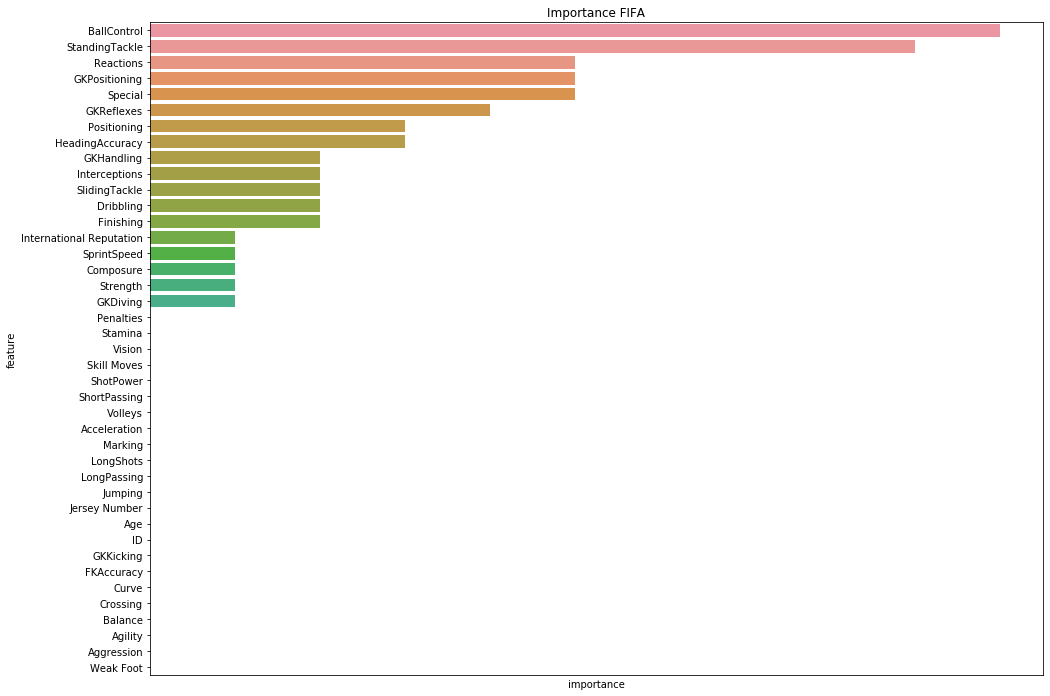

In [94]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))
plot_feature_importance(feature_importance, title = 'Importance FIFA')

#### XGB Prediction 

In [95]:
def train_xgb(X_train, X_valid, y_train, y_valid, params=None):

    model = xgb.XGBRegressor(**params) # Change here
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric="rmse", # Change here
            verbose=1, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)

    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance

In [98]:
xgb_params = { # Change here
          'n_estimators':500,
          'max_depth': 4,
          'learning_rate': 0.02,
          'min_child_weight': 2, 
          'gamma': 0, 
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          "booster": "gbtree",
          'nthread': 8,
        "loss_function":'mse',
         }

In [99]:
y_pred_train, y_pred_test, feature_importance = train_xgb(X_train, X_test, y_train, y_test, params=xgb_params)

[15:33:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:64.7747	validation_1-rmse:64.8227
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 50 rounds.
[1]	validation_0-rmse:63.4847	validation_1-rmse:63.532
[2]	validation_0-rmse:62.2204	validation_1-rmse:62.268
[3]	validation_0-rmse:60.9806	validation_1-rmse:61.0277
[4]	validation_0-rmse:59.7662	validation_1-rmse:59.8134
[5]	validation_0-rmse:58.5756	validation_1-rmse:58.6231
[6]	validation_0-rmse:57.4092	validation_1-rmse:57.4571
[7]	validation_0-rmse:56.2659	validation_1-rmse:56.3146
[8]	validation_0-rmse:55.1455	validation_1-rmse:55.194
[9]	validation_0-rmse:54.0472	validation_1-rmse:54.0951
[10]	validation_0-rmse:52.9708	validation_1-rmse:53.0189
[11]	validation_0-rmse:51.9159	validation_1-rmse:51.9638
[12]	validation_0-rmse:50.8828	validation_1

[139]	validation_0-rmse:4.33672	validation_1-rmse:4.38516
[140]	validation_0-rmse:4.26338	validation_1-rmse:4.31199
[141]	validation_0-rmse:4.19197	validation_1-rmse:4.241
[142]	validation_0-rmse:4.12216	validation_1-rmse:4.17105
[143]	validation_0-rmse:4.05345	validation_1-rmse:4.10233
[144]	validation_0-rmse:3.98629	validation_1-rmse:4.035
[145]	validation_0-rmse:3.92115	validation_1-rmse:3.96984
[146]	validation_0-rmse:3.85749	validation_1-rmse:3.9065
[147]	validation_0-rmse:3.79447	validation_1-rmse:3.84395
[148]	validation_0-rmse:3.73314	validation_1-rmse:3.78295
[149]	validation_0-rmse:3.67308	validation_1-rmse:3.72297
[150]	validation_0-rmse:3.6149	validation_1-rmse:3.6645
[151]	validation_0-rmse:3.55762	validation_1-rmse:3.60724
[152]	validation_0-rmse:3.50154	validation_1-rmse:3.55124
[153]	validation_0-rmse:3.44716	validation_1-rmse:3.49682
[154]	validation_0-rmse:3.39369	validation_1-rmse:3.44349
[155]	validation_0-rmse:3.34165	validation_1-rmse:3.39166
[156]	validation_0-rm

[281]	validation_0-rmse:1.44289	validation_1-rmse:1.50075
[282]	validation_0-rmse:1.44005	validation_1-rmse:1.49811
[283]	validation_0-rmse:1.43842	validation_1-rmse:1.49666
[284]	validation_0-rmse:1.43688	validation_1-rmse:1.49534
[285]	validation_0-rmse:1.43465	validation_1-rmse:1.49315
[286]	validation_0-rmse:1.43248	validation_1-rmse:1.49113
[287]	validation_0-rmse:1.4299	validation_1-rmse:1.4884
[288]	validation_0-rmse:1.42836	validation_1-rmse:1.48681
[289]	validation_0-rmse:1.42674	validation_1-rmse:1.48523
[290]	validation_0-rmse:1.42441	validation_1-rmse:1.48293
[291]	validation_0-rmse:1.42255	validation_1-rmse:1.48134
[292]	validation_0-rmse:1.41973	validation_1-rmse:1.47857
[293]	validation_0-rmse:1.4173	validation_1-rmse:1.47607
[294]	validation_0-rmse:1.41608	validation_1-rmse:1.47487
[295]	validation_0-rmse:1.41364	validation_1-rmse:1.47263
[296]	validation_0-rmse:1.41085	validation_1-rmse:1.46979
[297]	validation_0-rmse:1.40897	validation_1-rmse:1.46787
[298]	validation_

[423]	validation_0-rmse:1.24571	validation_1-rmse:1.32086
[424]	validation_0-rmse:1.24397	validation_1-rmse:1.31963
[425]	validation_0-rmse:1.24318	validation_1-rmse:1.3188
[426]	validation_0-rmse:1.24223	validation_1-rmse:1.31798
[427]	validation_0-rmse:1.24141	validation_1-rmse:1.31714
[428]	validation_0-rmse:1.24014	validation_1-rmse:1.31621
[429]	validation_0-rmse:1.23931	validation_1-rmse:1.31547
[430]	validation_0-rmse:1.23825	validation_1-rmse:1.31458
[431]	validation_0-rmse:1.23739	validation_1-rmse:1.31374
[432]	validation_0-rmse:1.23655	validation_1-rmse:1.31302
[433]	validation_0-rmse:1.23561	validation_1-rmse:1.31245
[434]	validation_0-rmse:1.2343	validation_1-rmse:1.3112
[435]	validation_0-rmse:1.23337	validation_1-rmse:1.31023
[436]	validation_0-rmse:1.2323	validation_1-rmse:1.30946
[437]	validation_0-rmse:1.23179	validation_1-rmse:1.30909
[438]	validation_0-rmse:1.23113	validation_1-rmse:1.30844
[439]	validation_0-rmse:1.23051	validation_1-rmse:1.30789
[440]	validation_0

[565]	validation_0-rmse:1.13547	validation_1-rmse:1.23005
[566]	validation_0-rmse:1.13497	validation_1-rmse:1.22951
[567]	validation_0-rmse:1.13421	validation_1-rmse:1.22881
[568]	validation_0-rmse:1.13347	validation_1-rmse:1.22826
[569]	validation_0-rmse:1.13248	validation_1-rmse:1.22755
[570]	validation_0-rmse:1.13189	validation_1-rmse:1.22709
[571]	validation_0-rmse:1.13142	validation_1-rmse:1.22667
[572]	validation_0-rmse:1.13061	validation_1-rmse:1.22605
[573]	validation_0-rmse:1.13015	validation_1-rmse:1.2257
[574]	validation_0-rmse:1.12919	validation_1-rmse:1.22489
[575]	validation_0-rmse:1.12853	validation_1-rmse:1.22446
[576]	validation_0-rmse:1.12801	validation_1-rmse:1.224
[577]	validation_0-rmse:1.12756	validation_1-rmse:1.22359
[578]	validation_0-rmse:1.12671	validation_1-rmse:1.22287
[579]	validation_0-rmse:1.12619	validation_1-rmse:1.22263
[580]	validation_0-rmse:1.12567	validation_1-rmse:1.22223
[581]	validation_0-rmse:1.12488	validation_1-rmse:1.22166
[582]	validation_

[707]	validation_0-rmse:1.05696	validation_1-rmse:1.16955
[708]	validation_0-rmse:1.05658	validation_1-rmse:1.16916
[709]	validation_0-rmse:1.05614	validation_1-rmse:1.1689
[710]	validation_0-rmse:1.05561	validation_1-rmse:1.16861
[711]	validation_0-rmse:1.05533	validation_1-rmse:1.16845
[712]	validation_0-rmse:1.05481	validation_1-rmse:1.16809
[713]	validation_0-rmse:1.05404	validation_1-rmse:1.16732
[714]	validation_0-rmse:1.05342	validation_1-rmse:1.16691
[715]	validation_0-rmse:1.05264	validation_1-rmse:1.16657
[716]	validation_0-rmse:1.05235	validation_1-rmse:1.16635
[717]	validation_0-rmse:1.05199	validation_1-rmse:1.16609
[718]	validation_0-rmse:1.0516	validation_1-rmse:1.1658
[719]	validation_0-rmse:1.05137	validation_1-rmse:1.16568
[720]	validation_0-rmse:1.0511	validation_1-rmse:1.16558
[721]	validation_0-rmse:1.05069	validation_1-rmse:1.16524
[722]	validation_0-rmse:1.05037	validation_1-rmse:1.16495
[723]	validation_0-rmse:1.04994	validation_1-rmse:1.16473
[724]	validation_0

[849]	validation_0-rmse:1.00041	validation_1-rmse:1.12792
[850]	validation_0-rmse:1.00007	validation_1-rmse:1.12767
[851]	validation_0-rmse:0.999774	validation_1-rmse:1.12742
[852]	validation_0-rmse:0.999413	validation_1-rmse:1.12711
[853]	validation_0-rmse:0.999171	validation_1-rmse:1.12702
[854]	validation_0-rmse:0.998885	validation_1-rmse:1.1269
[855]	validation_0-rmse:0.99848	validation_1-rmse:1.12665
[856]	validation_0-rmse:0.997977	validation_1-rmse:1.12627
[857]	validation_0-rmse:0.997806	validation_1-rmse:1.12613
[858]	validation_0-rmse:0.997452	validation_1-rmse:1.12597
[859]	validation_0-rmse:0.997043	validation_1-rmse:1.12571
[860]	validation_0-rmse:0.996582	validation_1-rmse:1.12546
[861]	validation_0-rmse:0.996215	validation_1-rmse:1.12515
[862]	validation_0-rmse:0.995732	validation_1-rmse:1.12496
[863]	validation_0-rmse:0.995235	validation_1-rmse:1.12467
[864]	validation_0-rmse:0.9949	validation_1-rmse:1.12445
[865]	validation_0-rmse:0.994613	validation_1-rmse:1.1242
[866

KeyboardInterrupt: 

0.0
0.0


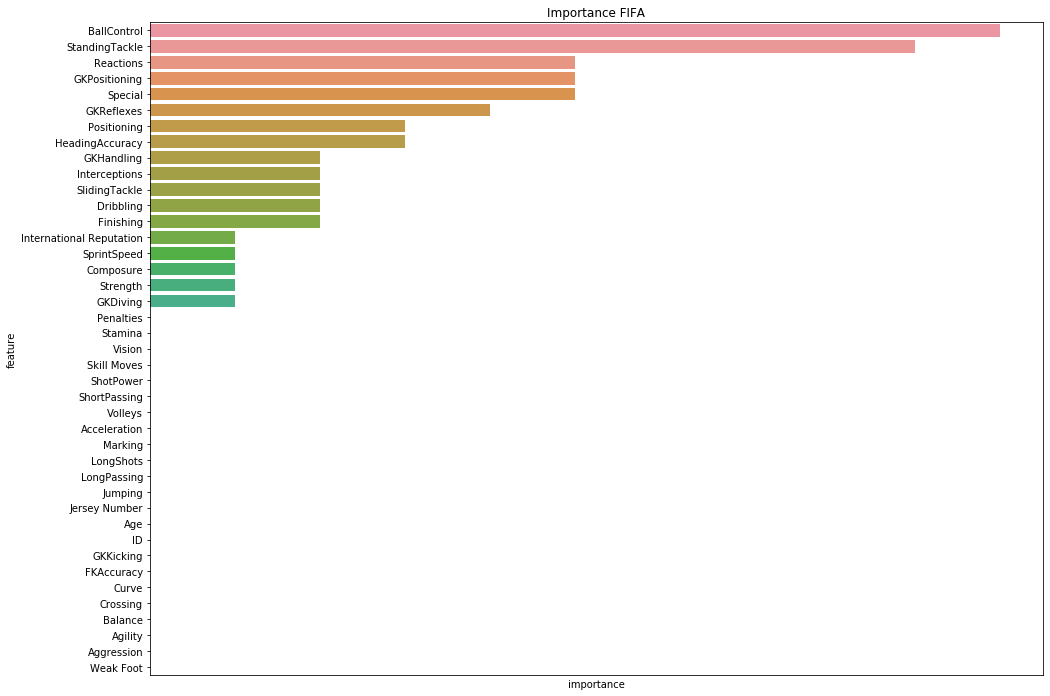

In [100]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))
plot_feature_importance(feature_importance, title = 'Importance FIFA')

#### Catboost Prediction

In [120]:
def train_catboost(X_train, X_valid, y_train, y_valid, params=None):

    model = catboost.CatBoostRegressor(**params) # Change here
    model.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], # Change here
            verbose=1, early_stopping_rounds=50)

    y_pred_train = model.predict(X_train)
    y_pred_valid = model.predict(X_valid)
    
    print("Best score", model.get_best_score())

    importance = pd.DataFrame()
    importance["feature"] = X.columns
    importance["importance"] = model.feature_importances_
    return y_pred_train, y_pred_valid, importance

In [121]:
catboost_params = { # Change here
          'n_estimators':500,
          'max_depth': 4,
          'learning_rate': 0.001,
          'rsm': 0.8,
          'objective': 'RMSE',
        "loss_function":'RMSE',
#     'eval_metric': "Accuracy"
         }

In [122]:
y_pred_train, y_pred_test, feature_importance = train_catboost(X_train, X_test, y_train, y_test, params=catboost_params)

0:	learn: 6.9270632	test: 6.9270632	test1: 6.8123337	best: 6.8123337 (0)	total: 13.7ms	remaining: 6.85s
1:	learn: 6.9223741	test: 6.9223741	test1: 6.8076209	best: 6.8076209 (1)	total: 27.5ms	remaining: 6.84s
2:	learn: 6.9178463	test: 6.9178463	test1: 6.8031517	best: 6.8031517 (2)	total: 51.3ms	remaining: 8.5s
3:	learn: 6.9132856	test: 6.9132856	test1: 6.7986046	best: 6.7986046 (3)	total: 66.4ms	remaining: 8.23s
4:	learn: 6.9088669	test: 6.9088669	test1: 6.7942507	best: 6.7942507 (4)	total: 80ms	remaining: 7.92s
5:	learn: 6.9043909	test: 6.9043909	test1: 6.7897733	best: 6.7897733 (5)	total: 96.4ms	remaining: 7.93s
6:	learn: 6.8996431	test: 6.8996431	test1: 6.7850031	best: 6.7850031 (6)	total: 108ms	remaining: 7.57s
7:	learn: 6.8950207	test: 6.8950207	test1: 6.7803956	best: 6.7803956 (7)	total: 120ms	remaining: 7.36s
8:	learn: 6.8906869	test: 6.8906869	test1: 6.7760743	best: 6.7760743 (8)	total: 131ms	remaining: 7.15s
9:	learn: 6.8860816	test: 6.8860816	test1: 6.7714242	best: 6.7714242 (

87:	learn: 6.5427189	test: 6.5427189	test1: 6.4299736	best: 6.4299736 (87)	total: 1.91s	remaining: 8.95s
88:	learn: 6.5384204	test: 6.5384204	test1: 6.4256491	best: 6.4256491 (88)	total: 1.94s	remaining: 8.97s
89:	learn: 6.5343254	test: 6.5343254	test1: 6.4215928	best: 6.4215928 (89)	total: 1.96s	remaining: 8.95s
90:	learn: 6.5301786	test: 6.5301786	test1: 6.4174986	best: 6.4174986 (90)	total: 1.99s	remaining: 8.94s
91:	learn: 6.5259994	test: 6.5259994	test1: 6.4133516	best: 6.4133516 (91)	total: 2s	remaining: 8.88s
92:	learn: 6.5217273	test: 6.5217273	test1: 6.4090624	best: 6.4090624 (92)	total: 2.02s	remaining: 8.82s
93:	learn: 6.5175109	test: 6.5175109	test1: 6.4049064	best: 6.4049064 (93)	total: 2.03s	remaining: 8.79s
94:	learn: 6.5133777	test: 6.5133777	test1: 6.4007859	best: 6.4007859 (94)	total: 2.05s	remaining: 8.72s
95:	learn: 6.5091211	test: 6.5091211	test1: 6.3965976	best: 6.3965976 (95)	total: 2.06s	remaining: 8.66s
96:	learn: 6.5051453	test: 6.5051453	test1: 6.3926205	best

168:	learn: 6.2152698	test: 6.2152698	test1: 6.1043356	best: 6.1043356 (168)	total: 3.86s	remaining: 7.55s
169:	learn: 6.2114610	test: 6.2114610	test1: 6.1005255	best: 6.1005255 (169)	total: 3.88s	remaining: 7.54s
170:	learn: 6.2075217	test: 6.2075217	test1: 6.0965937	best: 6.0965937 (170)	total: 3.9s	remaining: 7.51s
171:	learn: 6.2038182	test: 6.2038182	test1: 6.0929194	best: 6.0929194 (171)	total: 3.92s	remaining: 7.48s
172:	learn: 6.2001252	test: 6.2001252	test1: 6.0892327	best: 6.0892327 (172)	total: 3.95s	remaining: 7.47s
173:	learn: 6.1963613	test: 6.1963613	test1: 6.0854985	best: 6.0854985 (173)	total: 3.97s	remaining: 7.43s
174:	learn: 6.1923872	test: 6.1923872	test1: 6.0815473	best: 6.0815473 (174)	total: 3.98s	remaining: 7.39s
175:	learn: 6.1884560	test: 6.1884560	test1: 6.0775903	best: 6.0775903 (175)	total: 3.99s	remaining: 7.35s
176:	learn: 6.1845977	test: 6.1845977	test1: 6.0738375	best: 6.0738375 (176)	total: 4.01s	remaining: 7.31s
177:	learn: 6.1807498	test: 6.1807498	

249:	learn: 5.9148442	test: 5.9148442	test1: 5.8052881	best: 5.8052881 (249)	total: 5.29s	remaining: 5.29s
250:	learn: 5.9112635	test: 5.9112635	test1: 5.8017498	best: 5.8017498 (250)	total: 5.31s	remaining: 5.26s
251:	learn: 5.9077714	test: 5.9077714	test1: 5.7982727	best: 5.7982727 (251)	total: 5.33s	remaining: 5.24s
252:	learn: 5.9042609	test: 5.9042609	test1: 5.7948282	best: 5.7948282 (252)	total: 5.35s	remaining: 5.22s
253:	learn: 5.9008259	test: 5.9008259	test1: 5.7914588	best: 5.7914588 (253)	total: 5.36s	remaining: 5.2s
254:	learn: 5.8973135	test: 5.8973135	test1: 5.7880073	best: 5.7880073 (254)	total: 5.38s	remaining: 5.17s
255:	learn: 5.8938304	test: 5.8938304	test1: 5.7845184	best: 5.7845184 (255)	total: 5.39s	remaining: 5.14s
256:	learn: 5.8903008	test: 5.8903008	test1: 5.7810403	best: 5.7810403 (256)	total: 5.4s	remaining: 5.11s
257:	learn: 5.8867505	test: 5.8867505	test1: 5.7775115	best: 5.7775115 (257)	total: 5.42s	remaining: 5.08s
258:	learn: 5.8832015	test: 5.8832015	t

339:	learn: 5.6101319	test: 5.6101319	test1: 5.5023608	best: 5.5023608 (339)	total: 6.73s	remaining: 3.17s
340:	learn: 5.6069549	test: 5.6069549	test1: 5.4991798	best: 5.4991798 (340)	total: 6.75s	remaining: 3.15s
341:	learn: 5.6036763	test: 5.6036763	test1: 5.4959183	best: 5.4959183 (341)	total: 6.77s	remaining: 3.13s
342:	learn: 5.6004342	test: 5.6004342	test1: 5.4926937	best: 5.4926937 (342)	total: 6.79s	remaining: 3.11s
343:	learn: 5.5971551	test: 5.5971551	test1: 5.4894333	best: 5.4894333 (343)	total: 6.81s	remaining: 3.09s
344:	learn: 5.5939814	test: 5.5939814	test1: 5.4863155	best: 5.4863155 (344)	total: 6.82s	remaining: 3.06s
345:	learn: 5.5907316	test: 5.5907316	test1: 5.4830940	best: 5.4830940 (345)	total: 6.84s	remaining: 3.04s
346:	learn: 5.5875002	test: 5.5875002	test1: 5.4798347	best: 5.4798347 (346)	total: 6.86s	remaining: 3.02s
347:	learn: 5.5843111	test: 5.5843111	test1: 5.4767159	best: 5.4767159 (347)	total: 6.87s	remaining: 3s
348:	learn: 5.5810953	test: 5.5810953	te

416:	learn: 5.3713220	test: 5.3713220	test1: 5.2652500	best: 5.2652500 (416)	total: 8s	remaining: 1.59s
417:	learn: 5.3683159	test: 5.3683159	test1: 5.2622466	best: 5.2622466 (417)	total: 8.01s	remaining: 1.57s
418:	learn: 5.3653281	test: 5.3653281	test1: 5.2592554	best: 5.2592554 (418)	total: 8.02s	remaining: 1.55s
419:	learn: 5.3622157	test: 5.3622157	test1: 5.2561636	best: 5.2561636 (419)	total: 8.05s	remaining: 1.53s
420:	learn: 5.3591776	test: 5.3591776	test1: 5.2531414	best: 5.2531414 (420)	total: 8.06s	remaining: 1.51s
421:	learn: 5.3561550	test: 5.3561550	test1: 5.2501651	best: 5.2501651 (421)	total: 8.07s	remaining: 1.49s
422:	learn: 5.3533136	test: 5.3533136	test1: 5.2473577	best: 5.2473577 (422)	total: 8.09s	remaining: 1.47s
423:	learn: 5.3502672	test: 5.3502672	test1: 5.2443398	best: 5.2443398 (423)	total: 8.1s	remaining: 1.45s
424:	learn: 5.3472616	test: 5.3472616	test1: 5.2413169	best: 5.2413169 (424)	total: 8.12s	remaining: 1.43s
425:	learn: 5.3443528	test: 5.3443528	tes

495:	learn: 5.1446922	test: 5.1446922	test1: 5.0399902	best: 5.0399902 (495)	total: 9.48s	remaining: 76.4ms
496:	learn: 5.1419535	test: 5.1419535	test1: 5.0372982	best: 5.0372982 (496)	total: 9.51s	remaining: 57.4ms
497:	learn: 5.1392053	test: 5.1392053	test1: 5.0345920	best: 5.0345920 (497)	total: 9.53s	remaining: 38.3ms
498:	learn: 5.1364944	test: 5.1364944	test1: 5.0319326	best: 5.0319326 (498)	total: 9.56s	remaining: 19.2ms
499:	learn: 5.1336877	test: 5.1336877	test1: 5.0291234	best: 5.0291234 (499)	total: 9.57s	remaining: 0us

bestTest = 5.029123438
bestIteration = 499

Best score {'learn': {'RMSE': 5.133687696016328}, 'validation_0': {'RMSE': 5.133687696016328}, 'validation_1': {'RMSE': 5.029123438078144}}


0.0
0.0


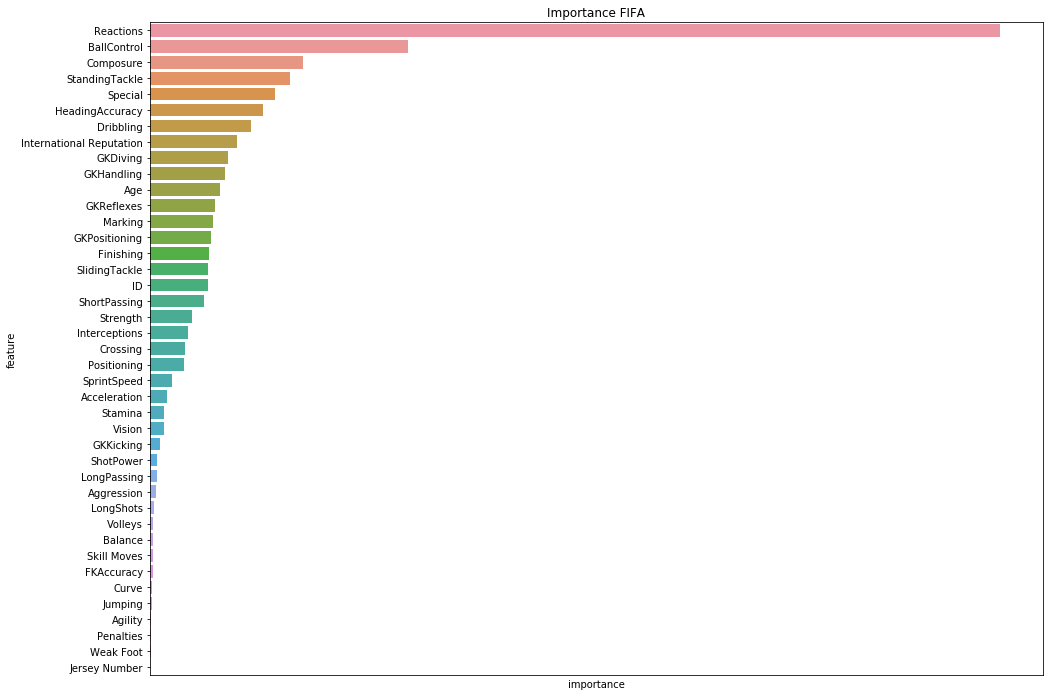

In [111]:
print(calc_accuracy(y_pred_train, y_train))
print(calc_accuracy(y_pred_test, y_test))
plot_feature_importance(feature_importance, title = 'Importance FIFA')

In [114]:
feature_importance

,feature,importance
0,ID,2.116563
1,Age,2.566637
2,Special,4.575074
3,International Reputation,3.177743
4,Weak Foot,0.022169
5,Skill Moves,0.102845
6,Jersey Number,0.009108
7,Crossing,1.278509
8,Finishing,2.152087
9,HeadingAccuracy,4.128624


### Objective: Predict `Value`

**Exercise**: Redo exercices on Week 1A with XGBoost and CatBoost, using the same Pandas data treatment. Finetune the XGBoost and CatBoost parameters and compare the accuracy of 3 methods